<a href="https://colab.research.google.com/github/JTumelty/Smart-Health/blob/main/week%201/ML_Smart_Health_Project1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Project 1**
**Aim:** Understand how to download Sleep Apnea datasets, extract and visualise HRV features and apply descriptive and inferential statistics to determine differences between healthy and apnea subjects.

**Notes:** This notebook is heavily based on the MLSH-L1-P3.ipynb notebook from the lecture, with additional comments to understand each step in the analysis.

**References:** 

*   Lecture notes
*   https://imotions.com/blog/heart-rate-variability/
*   https://en.wikipedia.org/wiki/Heart_rate_variability
*   https://www.firstbeat.com/en/blog/what-is-heart-rate-variability-hrv/
*   https://link.springer.com/article/10.1007/s11325-020-02249-0
*   https://pubmed.ncbi.nlm.nih.gov/28268989/
*   https://www.sciencedirect.com/science/article/abs/pii/S0010482517303244

## Setup
Install python packages for analysis.

In [ ]:
!pip install hrv-analysis #Python module for Heart Rate Variability analysis
!pip install wfdb #native Python waveform-database (WFDB) package

In [ ]:
# Python packages for display and analysis
from IPython.display import display

!pip install matplotlib==3.4.3
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import shutil
import posixpath
import wfdb

Download ECG records from PhysioNet Database

In [ ]:
# Download apnea-ECG records from the small PhysioNet Database: https://doi.org/10.13026/C23W2R

# Make a temporary download directory in your current working directory
cwd = os.getcwd()
dl_dir = os.path.join(cwd, 'tmp_dl_dir')

# Download all the WFDB content
wfdb.dl_database('apnea-ecg', dl_dir=dl_dir)

# Display the downloaded content in the folder
display(os.listdir(dl_dir))


Generating record list for: a01
Generating record list for: a01er
Generating record list for: a01r
Generating record list for: a02
Generating record list for: a02er
Generating record list for: a02r
Generating record list for: a03
Generating record list for: a03er
Generating record list for: a03r
Generating record list for: a04
Generating record list for: a04er
Generating record list for: a04r
Generating record list for: a05
Generating record list for: a06
Generating record list for: a07
Generating record list for: a08
Generating record list for: a09
Generating record list for: a10
Generating record list for: a11
Generating record list for: a12
Generating record list for: a13
Generating record list for: a14
Generating record list for: a15
Generating record list for: a16
Generating record list for: a17
Generating record list for: a18
Generating record list for: a19
Generating record list for: a20
Generating record list for: b01
Generating record list for: b01er
Generating record list for

['x03.apn',
 'a01.qrs',
 'x18.apn',
 'x35.dat',
 'x28.hea',
 'c04.hea',
 'a02r.apn',
 'a19.dat',
 'a03er.qrs',
 'x04.dat',
 'a11.apn',
 'a03er.hea',
 'b04.hea',
 'b02.apn',
 'a16.dat',
 'x34.apn',
 'a03r.dat',
 'x25.hea',
 'x19.hea',
 'c06.hea',
 'x34.qrs',
 'a15.qrs',
 'a04.dat',
 'x10.qrs',
 'x01.hea',
 'a06.hea',
 'a01.apn',
 'x12.dat',
 'x16.qrs',
 'x06.dat',
 'x26.hea',
 'x31.dat',
 'a04er.qrs',
 'x02.apn',
 'x24.apn',
 'c03r.apn',
 'b01r.dat',
 'a19.qrs',
 'a01r.apn',
 'c01r.apn',
 'x15.dat',
 'x28.apn',
 'a10.apn',
 'x30.dat',
 'a11.hea',
 'x10.hea',
 'x01.dat',
 'x22.hea',
 'x31.hea',
 'c03er.apn',
 'a01.dat',
 'x06.apn',
 'x35.apn',
 'a04r.dat',
 'a14.qrs',
 'c08.qrs',
 'x22.dat',
 'x24.hea',
 'x08.qrs',
 'x35.qrs',
 'a05.qrs',
 'x14.qrs',
 'x23.apn',
 'c08.hea',
 'b01r.hea',
 'c06.qrs',
 'a18.hea',
 'b03.qrs',
 'x03.hea',
 'b01er.hea',
 'a20.qrs',
 'a14.dat',
 'x21.dat',
 'x18.dat',
 'c08.dat',
 'x02.dat',
 'x20.dat',
 'x33.apn',
 'x12.hea',
 'a17.apn',
 'b05.apn',
 'a17.hea'

# Project


In [ ]:
# Import useful functions
!pip install biosppy
import biosppy
from hrvanalysis import remove_ectopic_beats, interpolate_nan_values, get_time_domain_features, get_frequency_domain_features, get_geometrical_features
from hrvanalysis import get_csi_cvi_features, get_poincare_plot_features
from hrvanalysis.extract_features import get_frequency_domain_features
import csv
import pandas as pd

In [ ]:
def get_record_features(record,rec_name):
  nn_interval = get_record_interval(record)

  # Populate results dictionary with time and freq features
  results = {}
  results = record_time_domain(results,nn_interval)
  results = record_freq_domain(results,nn_interval)

  # Add summary information from record_info.csv (AI, HI, H-healthy, A-Apnea, Age, Sex,
  # Height and Weight)

  # Add the name of the record
  results['record']=rec_name
  return results

In [ ]:
  def get_record_interval(record):
    ind= biosppy.signals.ecg.ecg(record.p_signal[:,0], sampling_rate=100, show=False)
    # Find index differences between successive R peaks.
    rr_ind = np.diff(ind['rpeaks'])
    rr_ms = [element * 10 for element in rr_ind] 
    # Remove ectopic beats
    ect_ind = remove_ectopic_beats(rr_ms)
    nn_interval = interpolate_nan_values(rr_intervals=ect_ind)
    
    return nn_interval

In [ ]:
 def record_time_domain(results,nn_interval): 
  # Time domain
  time_dict = get_time_domain_features(nn_interval)
  results['avnn'] = time_dict['mean_nni']
  results['hr'] = time_dict['mean_hr']
  results['SDNN'] = time_dict['sdnn']
  results['pNN50'] = time_dict['pnni_20']
  results['RMSSD'] = time_dict['rmssd']
  results['HRdiff'] = time_dict['max_hr'] - time_dict['min_hr']
  return results

In [ ]:
def record_freq_domain(results,nn_interval):
  # Frequency domain
  freq_dict = get_frequency_domain_features(nn_interval)
  results['VLF'] = freq_dict['vlf']
  results['LF'] = freq_dict['lf']
  results['HF'] = freq_dict['hf']
  results['LHFratio'] = freq_dict['lf_hf_ratio']
  return results

In [ ]:
# Find the list of records to consider
rec_list = list(set([os.path.splitext(x)[0] for x in os.listdir(dl_dir)]))
# Remove records of the form '...er', which are recordings with the four additional 
# signals that we will not consider here.
rec_list = [record for record in rec_list if record[-1]!='r']

In [ ]:
# Define variables for writing to features.csv
csv_file = "features.csv"
write_column = True
with open(csv_file, 'w') as csvfile:

# Iterate through list of records, load the ECG record and run get_record_features
# and write to features.csv
  for rec_name in rec_list:
    record = wfdb.rdrecord('tmp_dl_dir/'+rec_name, sampfrom=0,sampto=100000)
    results = get_record_features(record,rec_name)

    if write_column:
      csv_columns = results.keys()
      writer = csv.DictWriter(csvfile, fieldnames=csv_columns)
      writer.writeheader()
      write_column = False

    writer.writerow(results)

37 ectopic beat(s) have been deleted with malik rule.
889 ectopic beat(s) have been deleted with malik rule.
594 ectopic beat(s) have been deleted with malik rule.
4 ectopic beat(s) have been deleted with malik rule.
0 ectopic beat(s) have been deleted with malik rule.
101 ectopic beat(s) have been deleted with malik rule.
21 ectopic beat(s) have been deleted with malik rule.
9 ectopic beat(s) have been deleted with malik rule.
11 ectopic beat(s) have been deleted with malik rule.
260 ectopic beat(s) have been deleted with malik rule.
40 ectopic beat(s) have been deleted with malik rule.
262 ectopic beat(s) have been deleted with malik rule.
47 ectopic beat(s) have been deleted with malik rule.
177 ectopic beat(s) have been deleted with malik rule.
0 ectopic beat(s) have been deleted with malik rule.
54 ectopic beat(s) have been deleted with malik rule.
18 ectopic beat(s) have been deleted with malik rule.
40 ectopic beat(s) have been deleted with malik rule.
111 ectopic beat(s) have b

Use data description to classify the patients with and without sleep apnea.

In [ ]:
# Start by looking at the additional information on:
# https://physionet.org/content/apnea-ecg/1.0.0/additional-information.txt
# to determine those patients that have sleep apnea and those that do not.
# Note that this cell requires record_info.csv file, which is the tabulated data
# from the linked .txt file 

# Make a pd dataframe with 'Record' as index. Replace '' characters around columns
# and Record and Sex entries
record_info = pd.read_csv('record_info.csv')
record_info.columns = record_info.columns.str.replace("'","")
record_info['Record'] = record_info['Record'].str.replace("'", '')
record_info['Sex'] = record_info['Sex'].str.replace("'", '')
record_info = record_info.set_index('Record')
record_info.head()


,Length minutes,Non-apn minutes,apnea minutes,hours w/apnea,AI,HI,AHI,Age,Sex,height (cm),weight (kg)
Record,,,,,,,,,,,
a01,490,20,470,9,12.5,57.1,69.6,51,M,175,102
a02,529,109,420,9,57.2,12.3,69.5,38,M,180,120
a03,520,274,246,9,38.4,0.7,39.1,54,M,168,80
a04,493,40,453,9,73.4,4.0,77.4,52,M,173,121
a05,455,179,276,8,35.0,6.0,41.0,58,M,176,78


In [ ]:
# Add a new column with value A is hours w/apnea > 0 and H otherwise
record_info['class_A_or_H'] = np.where(record_info['hours w/apnea']>0, 'A','H')

In [ ]:
# Load in features.csv as pd DataFrame and make record the index
features = pd.read_csv('features.csv')
features = features.set_index('record')
features.head()

,avnn,hr,SDNN,pNN50,RMSSD,HRdiff,VLF,LF,HF,LHFratio
record,,,,,,,,,,
x33,714.964209,85.708406,81.202893,34.455587,45.767492,291.085506,7.587059e+02,1.497610e+03,9.358604e+02,1.600249
c04,415.305247,183.813548,324.193980,79.707219,158.203650,592.592593,3.795155e+03,7.361758e+03,9.588733e+03,0.767751
c09,829.665104,170.373924,7969.133945,75.938338,6427.789387,999.760546,7.093625e+07,1.011680e+07,1.813533e+06,5.578502
a20,889.518717,67.792461,49.456368,18.465656,30.572883,189.393939,5.508039e+02,3.937700e+02,2.818294e+02,1.397193
x08,898.129496,66.948810,41.150307,15.391539,18.364741,16.923077,7.484655e+02,5.081830e+02,7.743127e+01,6.563020


In [ ]:
# Merge the features database with the record_info database
all_records = pd.merge(record_info,features,left_index=True,right_index=True).head(70)
all_records.head(70)

,Length minutes,Non-apn minutes,apnea minutes,hours w/apnea,AI,HI,AHI,Age,Sex,height (cm),weight (kg),class_A_or_H,avnn,hr,SDNN,pNN50,RMSSD,HRdiff,VLF,LF,HF,LHFratio
a01,490,20,470,9,12.50,57.1,69.60,51,M,175,102,A,831.513761,73.040629,90.699505,47.245409,43.322470,45.454545,1.253066e+03,1.672205e+03,6.630697e+02,2.521914
a02,529,109,420,9,57.20,12.3,69.50,38,M,180,120,A,755.933485,84.557358,64.424733,9.077156,37.133484,5941.747573,9.715965e+02,7.729338e+02,4.106547e+02,1.882199
a03,520,274,246,9,38.40,0.7,39.10,54,M,168,80,A,17441.346154,63.094282,101765.236602,57.281553,84112.241637,272.657110,4.589937e+08,7.046431e+07,6.001843e+06,11.740446
a04,493,40,453,9,73.40,4.0,77.40,52,M,173,121,A,729.207451,82.827238,48.530037,3.581871,27.266419,163.353500,4.430518e+02,2.851670e+02,2.091080e+02,1.363731
a05,455,179,276,8,35.00,6.0,41.00,58,M,176,78,A,990.203373,60.887498,67.965054,46.176763,36.608316,36.304962,1.592097e+03,1.088706e+03,3.806619e+02,2.860034
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
x31,558,42,516,10,86.80,6.7,93.50,29,F,183,100,A,991.212425,62.126889,148.427508,64.994985,67.483049,81.834532,3.483876e+03,2.125542e+03,1.022782e+03,2.078198
x32,539,114,425,9,63.30,8.5,71.80,29,F,183,100,A,1005.529768,60.645305,116.552528,76.969697,78.971930,124.553571,2.053907e+03,2.224366e+03,1.660136e+03,1.339870
x33,474,471,3,0,0.13,0.0,0.13,28,F,169,57,H,714.964209,85.708406,81.202893,34.455587,45.767492,291.085506,7.587059e+02,1.497610e+03,9.358604e+02,1.600249
x34,476,472,4,0,0.38,0.0,0.38,30,F,168,56,H,714.871060,85.805574,83.695243,35.340502,48.109791,291.716687,9.836190e+02,1.699065e+03,1.007047e+03,1.687175


In [ ]:
# Split into healthy and apnea records
apnea_records = all_records[all_records['class_A_or_H']=='A']
healthy_records = all_records[all_records['class_A_or_H']=='H']

## Statistical analysis


Start by pandas 'describe' to obtain numerical statistics for apneic and healthy records.

In [ ]:
apnea_records[features.columns].describe()

,avnn,hr,SDNN,pNN50,RMSSD,HRdiff,VLF,LF,HF,LHFratio
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,5.000000e+01,5.000000e+01,5.000000e+01,50.000000
mean,1177.205127,76.821219,2342.631704,29.528373,1889.152757,538.133200,1.046957e+07,1.483722e+06,1.266568e+05,5.029305
std,2349.570547,20.943258,14398.277495,23.172281,11895.655343,1444.511688,6.504153e+07,9.963171e+06,8.486339e+05,6.421474
min,488.181464,58.761388,32.960686,3.581871,13.125471,16.923077,2.197134e+02,2.357354e+02,3.274369e+01,0.752200
25%,774.318064,66.367587,50.222458,12.311215,23.322699,54.899583,7.063922e+02,5.282118e+02,1.732915e+02,1.931199
50%,845.955662,72.447940,68.149445,20.641631,33.031948,116.153229,9.651666e+02,8.687136e+02,3.398772e+02,2.937725
75%,925.128952,78.810542,98.192758,42.390059,59.873111,210.391963,2.044125e+03,2.220944e+03,1.011792e+03,5.007359
max,17441.346154,166.378184,101765.236602,84.177708,84112.241637,5976.284585,4.589937e+08,7.046431e+07,6.001843e+06,32.557475


In [ ]:
healthy_records[features.columns].describe()

,avnn,hr,SDNN,pNN50,RMSSD,HRdiff,VLF,LF,HF,LHFratio
count,20.000000,20.000000,20.000000,20.000000,20.000000,20.000000,2.000000e+01,2.000000e+01,2.000000e+01,20.000000
mean,951.939297,120.053667,3109.121185,69.798996,2335.415932,849.214231,1.952926e+07,1.172979e+06,1.649122e+05,7.992831
std,313.133198,45.349632,3810.754782,16.588170,2934.162840,1279.436272,2.633469e+07,2.323694e+06,4.100839e+05,7.702045
min,415.305247,48.668867,68.331607,34.455587,45.767492,32.972973,7.587059e+02,1.336172e+03,4.216943e+02,0.767751
25%,713.659114,82.456619,166.047818,62.799533,94.499128,313.980138,3.701775e+03,4.678454e+03,2.867763e+03,1.592643
50%,886.162892,136.739103,859.253416,76.129107,449.535389,597.466351,1.009214e+06,2.594677e+05,1.950467e+04,5.578583
75%,1170.526196,162.390704,5428.561841,82.306979,4230.021141,666.034125,3.375340e+07,1.041446e+06,8.924181e+04,10.821925
max,1710.571827,183.813548,10387.294675,85.373781,8147.339311,5999.716727,7.093625e+07,1.011680e+07,1.813533e+06,22.498659


Note that the max quantities in some features are much larger than the upper quartile, indicating some anomalies within the data that should be accounted for in future analysis. Descriptive statistics between the two groups. Here, we will consider the distribution of various features.

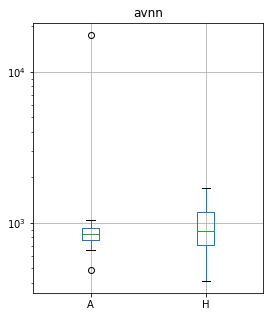

In [ ]:
# Boxplot for avnn
all_records.boxplot(column='avnn',by=all_records['class_A_or_H'],\
                         figsize=(4,5))
plt.yscale('log')
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments:** Larger variation in avnn (averate RR interval) across healthy records and distribution appears bimodal, whereas the distribution of avnn for apneic records is normally distributed centred around 845 (median).

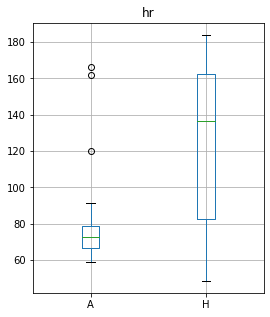

In [ ]:
# Boxplot for hr
all_records.boxplot(column='hr',by=all_records['class_A_or_H'],\
                         figsize=(4,5))
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments:** Larger variation in hr across healthy records and distribution appears more uniform **(why such high hr for some records?)**, whereas the distribution of hr for apneic records is normally distributed centred around 72 (median). Lower average hr in apneic records (72) to healthy records (120)

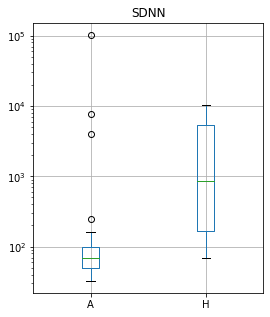

In [ ]:
# Boxplot for SDNN
all_records.boxplot(column='SDNN',by=all_records['class_A_or_H'],\
                         figsize=(4,5))
plt.yscale('log')
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments:** In apneic records, low SDNN (standard deviation of RR intervals) with IQR between 50 and 98. There is more variation in SDNN across healthy records with IQR between 68 and 5428 (both greater than apneic patients). This might be expected from the effects of sleep apnea on RR intervals

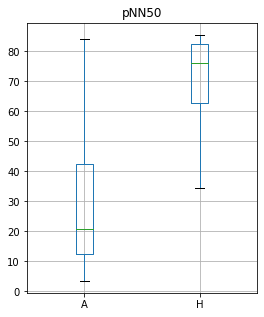

In [ ]:
# Boxplot forpNN50
all_records.boxplot(column='pNN50',by=all_records['class_A_or_H'],\
                         figsize=(4,5))
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments**: pNN50: percentage of absolute differences in successive NN values > 50 ms. This value is higher in healthy records, lower in apneic records. Skewed dataset.

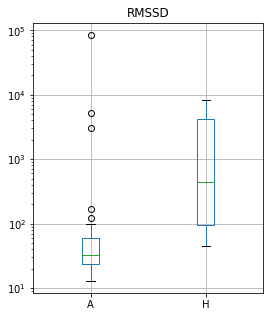

In [ ]:
# Boxplot for RMSSD
all_records.boxplot(column='RMSSD',by=all_records['class_A_or_H'],\
                         figsize=(4,5))
plt.yscale('log')
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments:** Similar conclusions to SDNN results

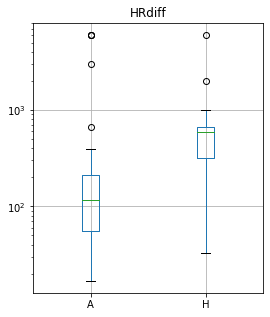

In [ ]:
# Boxplot for HRdiff
all_records.boxplot(column='HRdiff',by=all_records['class_A_or_H'],\
                         figsize=(4,5))
plt.yscale('log')
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments:** Larger difference in heart rates within healthy records. More skew in healthy records.

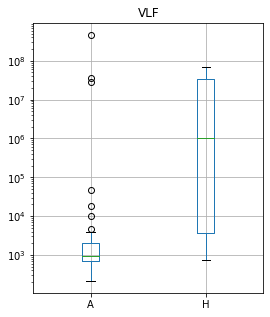

In [ ]:
# Boxplot for VLF
all_records.boxplot(column='VLF',by=all_records['class_A_or_H'],\
                         figsize=(4,5))
plt.yscale('log')
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments:** Larger variation in VLF, also higher values in healthy records compared to apneic records.

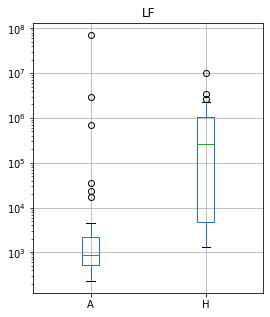

In [ ]:
# Boxplot for LF
all_records.boxplot(column='LF',by=all_records['class_A_or_H'],\
                         figsize=(4,5))
plt.yscale('log')
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments:** Similar comments to VLF.

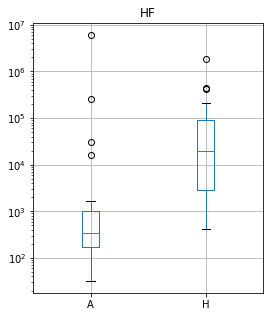

In [ ]:
# Boxplot for HF
all_records.boxplot(column='HF',by=all_records['class_A_or_H'],\
                         figsize=(4,5))

plt.yscale('log')
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments:** Similar comments to VLF.

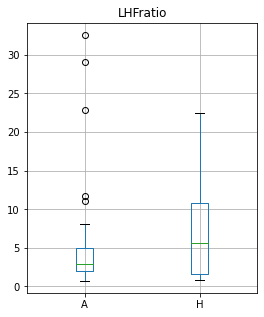

In [ ]:
# Boxplot for LHFratio
all_records.boxplot(column='LHFratio',by=all_records['class_A_or_H'],\
                         figsize=(4,5))
plt.xlabel('')
plt.suptitle('')
plt.show()

**Comments:** Similar distributions for LHF ratio between the two types of records.

Inferential statistics (e.g. t-test, Mann-Whitney U test) to find if there is any significant difference between the groups. 

In [ ]:
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu

print('avnn:',ttest_ind(apnea_records['avnn'], healthy_records['avnn']))
print('HR:',ttest_ind(apnea_records['hr'], healthy_records['hr']))
print('SDNN:',ttest_ind(apnea_records['SDNN'], healthy_records['SDNN']))
print('pNN50:',ttest_ind(apnea_records['pNN50'], healthy_records['pNN50']))
print('RMSSD:',ttest_ind(apnea_records['RMSSD'], healthy_records['RMSSD']))
print('HRdiff:',ttest_ind(apnea_records['HRdiff'], healthy_records['HRdiff']))
print('VLF:',ttest_ind(apnea_records['VLF'], healthy_records['VLF']))
print('LF:',ttest_ind(apnea_records['LF'], healthy_records['LF']))
print('HF:',ttest_ind(apnea_records['HF'], healthy_records['HF']))
print('LHFratio:',ttest_ind(apnea_records['LHFratio'], healthy_records['LHFratio']))
print('\n')
print('avnn:',mannwhitneyu(apnea_records['avnn'], healthy_records['avnn']))
print('HR:',mannwhitneyu(apnea_records['hr'], healthy_records['hr']))
print('SDNN:',mannwhitneyu(apnea_records['SDNN'], healthy_records['SDNN']))
print('pNN50:',mannwhitneyu(apnea_records['pNN50'], healthy_records['pNN50']))
print('RMSSD:',mannwhitneyu(apnea_records['RMSSD'], healthy_records['RMSSD']))
print('HRdiff:',mannwhitneyu(apnea_records['HRdiff'], healthy_records['HRdiff']))
print('VLF:',mannwhitneyu(apnea_records['VLF'], healthy_records['VLF']))
print('LF:',mannwhitneyu(apnea_records['LF'], healthy_records['LF']))
print('HF:',mannwhitneyu(apnea_records['HF'], healthy_records['HF']))
print('LHFratio:',mannwhitneyu(apnea_records['LHFratio'], healthy_records['LHFratio']))

avnn: Ttest_indResult(statistic=0.42542580548004394, pvalue=0.6718696752228657)
HR: Ttest_indResult(statistic=-5.47513919500193, pvalue=6.842376559073233e-07)
SDNN: Ttest_indResult(statistic=-0.23387490691717674, pvalue=0.8157847772846643)
pNN50: Ttest_indResult(statistic=-7.067570329304357, pvalue=1.071745949976072e-09)
RMSSD: Ttest_indResult(statistic=-0.1650999008605311, pvalue=0.869355185822965)
HRdiff: Ttest_indResult(statistic=-0.8396311151509893, pvalue=0.4040575561428428)
VLF: Ttest_indResult(statistic=-0.6013778927930091, pvalue=0.5495879535283733)
LF: Ttest_indResult(statistic=0.13742895995503954, pvalue=0.8910978574748042)
HF: Ttest_indResult(statistic=-0.19220209542264635, pvalue=0.8481567363916497)
LHFratio: Ttest_indResult(statistic=-1.6463478219501788, pvalue=0.10430664127244196)


avnn: MannwhitneyuResult(statistic=463.0, pvalue=0.31756465092721947)
HR: MannwhitneyuResult(statistic=213.0, pvalue=9.779118011899547e-05)
SDNN: MannwhitneyuResult(statistic=116.0, pvalue=3.0

Doing a TTest on each of the categories, we seem to find that the categories: HR and pNN50 are statistically significant to determine between the two groups. Perhaps the validity of using a ttest for many of these variables should be considered as many of the distributions are skewed and not normally distributed. The Mann--Whitney U-Test result appears to be a more useful test for determining which quantities are significantly different between healthy and apneic records. We find that all features bar avnn and LHFratio are significantly different between the two groups.

101 ectopic beat(s) have been deleted with malik rule.


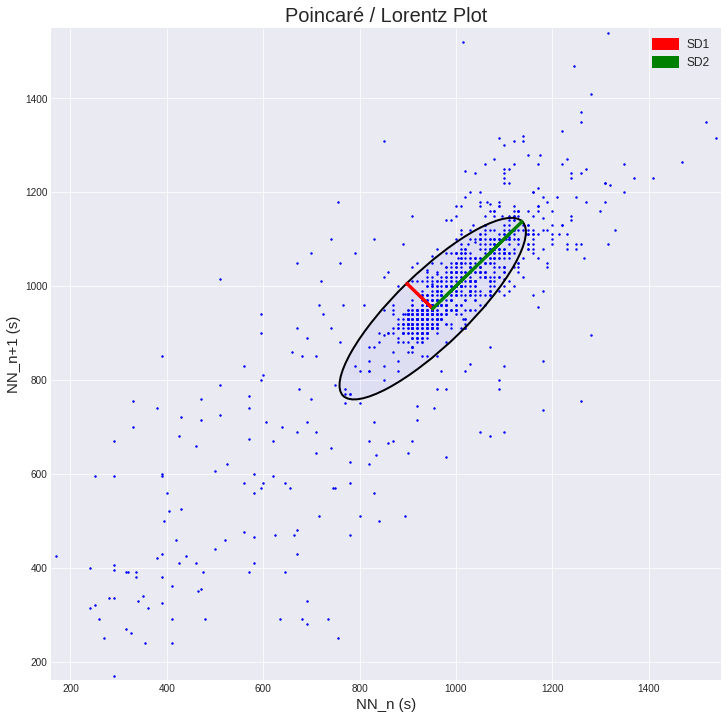

In [ ]:
# Plot Poincare plot features where you plot the current NN interval against the
# previous NN interval. Small (large) variability tends to be associated with (apnea)
# healthy subjects

from hrvanalysis import plot_poincare

print('Healthy Poincare Plot')
rec_name = healthy_records.sample(n=1).index[0]
record = wfdb.rdrecord('tmp_dl_dir/'+rec_name, sampfrom=0,sampto=100000)
nn_interval = get_record_interval(record)
plot_poincare(nn_interval, plot_sd_features=True)

Apnea Poincare Plot
0 ectopic beat(s) have been deleted with malik rule.


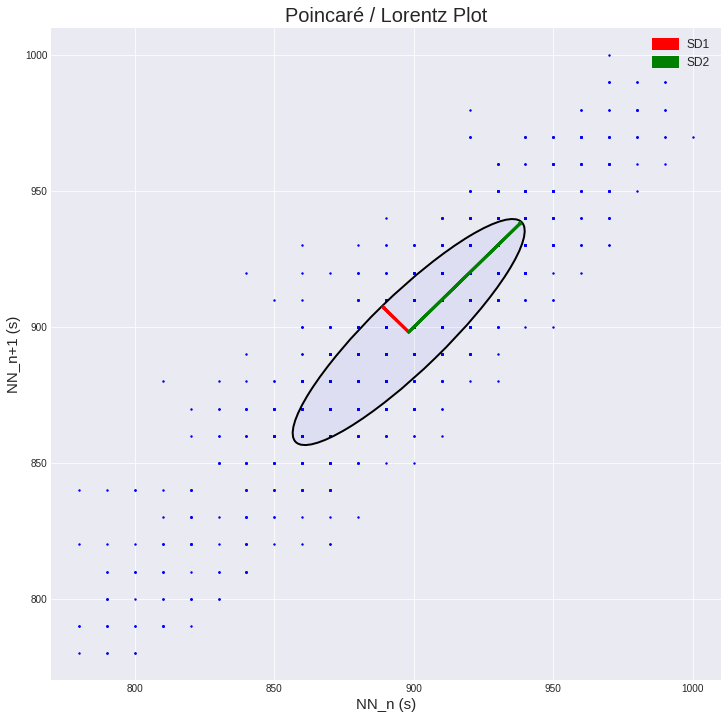

In [ ]:
# Plot Poincare plot features where you plot the current NN interval against the
# previous NN interval. Small (large) variability tends to be associated with (apnea)
# healthy subjects

from hrvanalysis import plot_poincare

print('Apnea Poincare Plot')
rec_name = apnea_records.sample(n=1).index[0]
record = wfdb.rdrecord('tmp_dl_dir/'+rec_name, sampfrom=0,sampto=100000)
nn_interval = get_record_interval(record)
plot_poincare(nn_interval, plot_sd_features=True)

As expected, the variability in the Poincare plot for apneic records are smaller than those for healthy records.